/home/jfaath/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


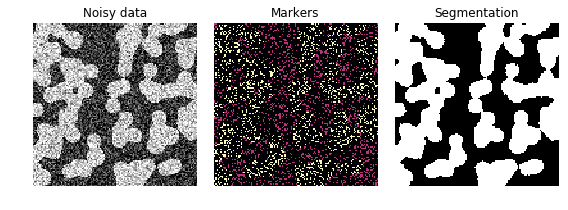

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

# Generate noisy synthetic data
data = skimage.img_as_float(binary_blobs(length=128, seed=1))
sigma = 0.35
data += np.random.normal(loc=0, scale=sigma, size=data.shape)
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma', interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray', interpolation='nearest')
ax3.axis('off')
ax3.set_adjustable('box-forced')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

(256, 256)
(array([27, 28]), array([163, 163]))
num markers: 1
(256, 256)
(256, 256)


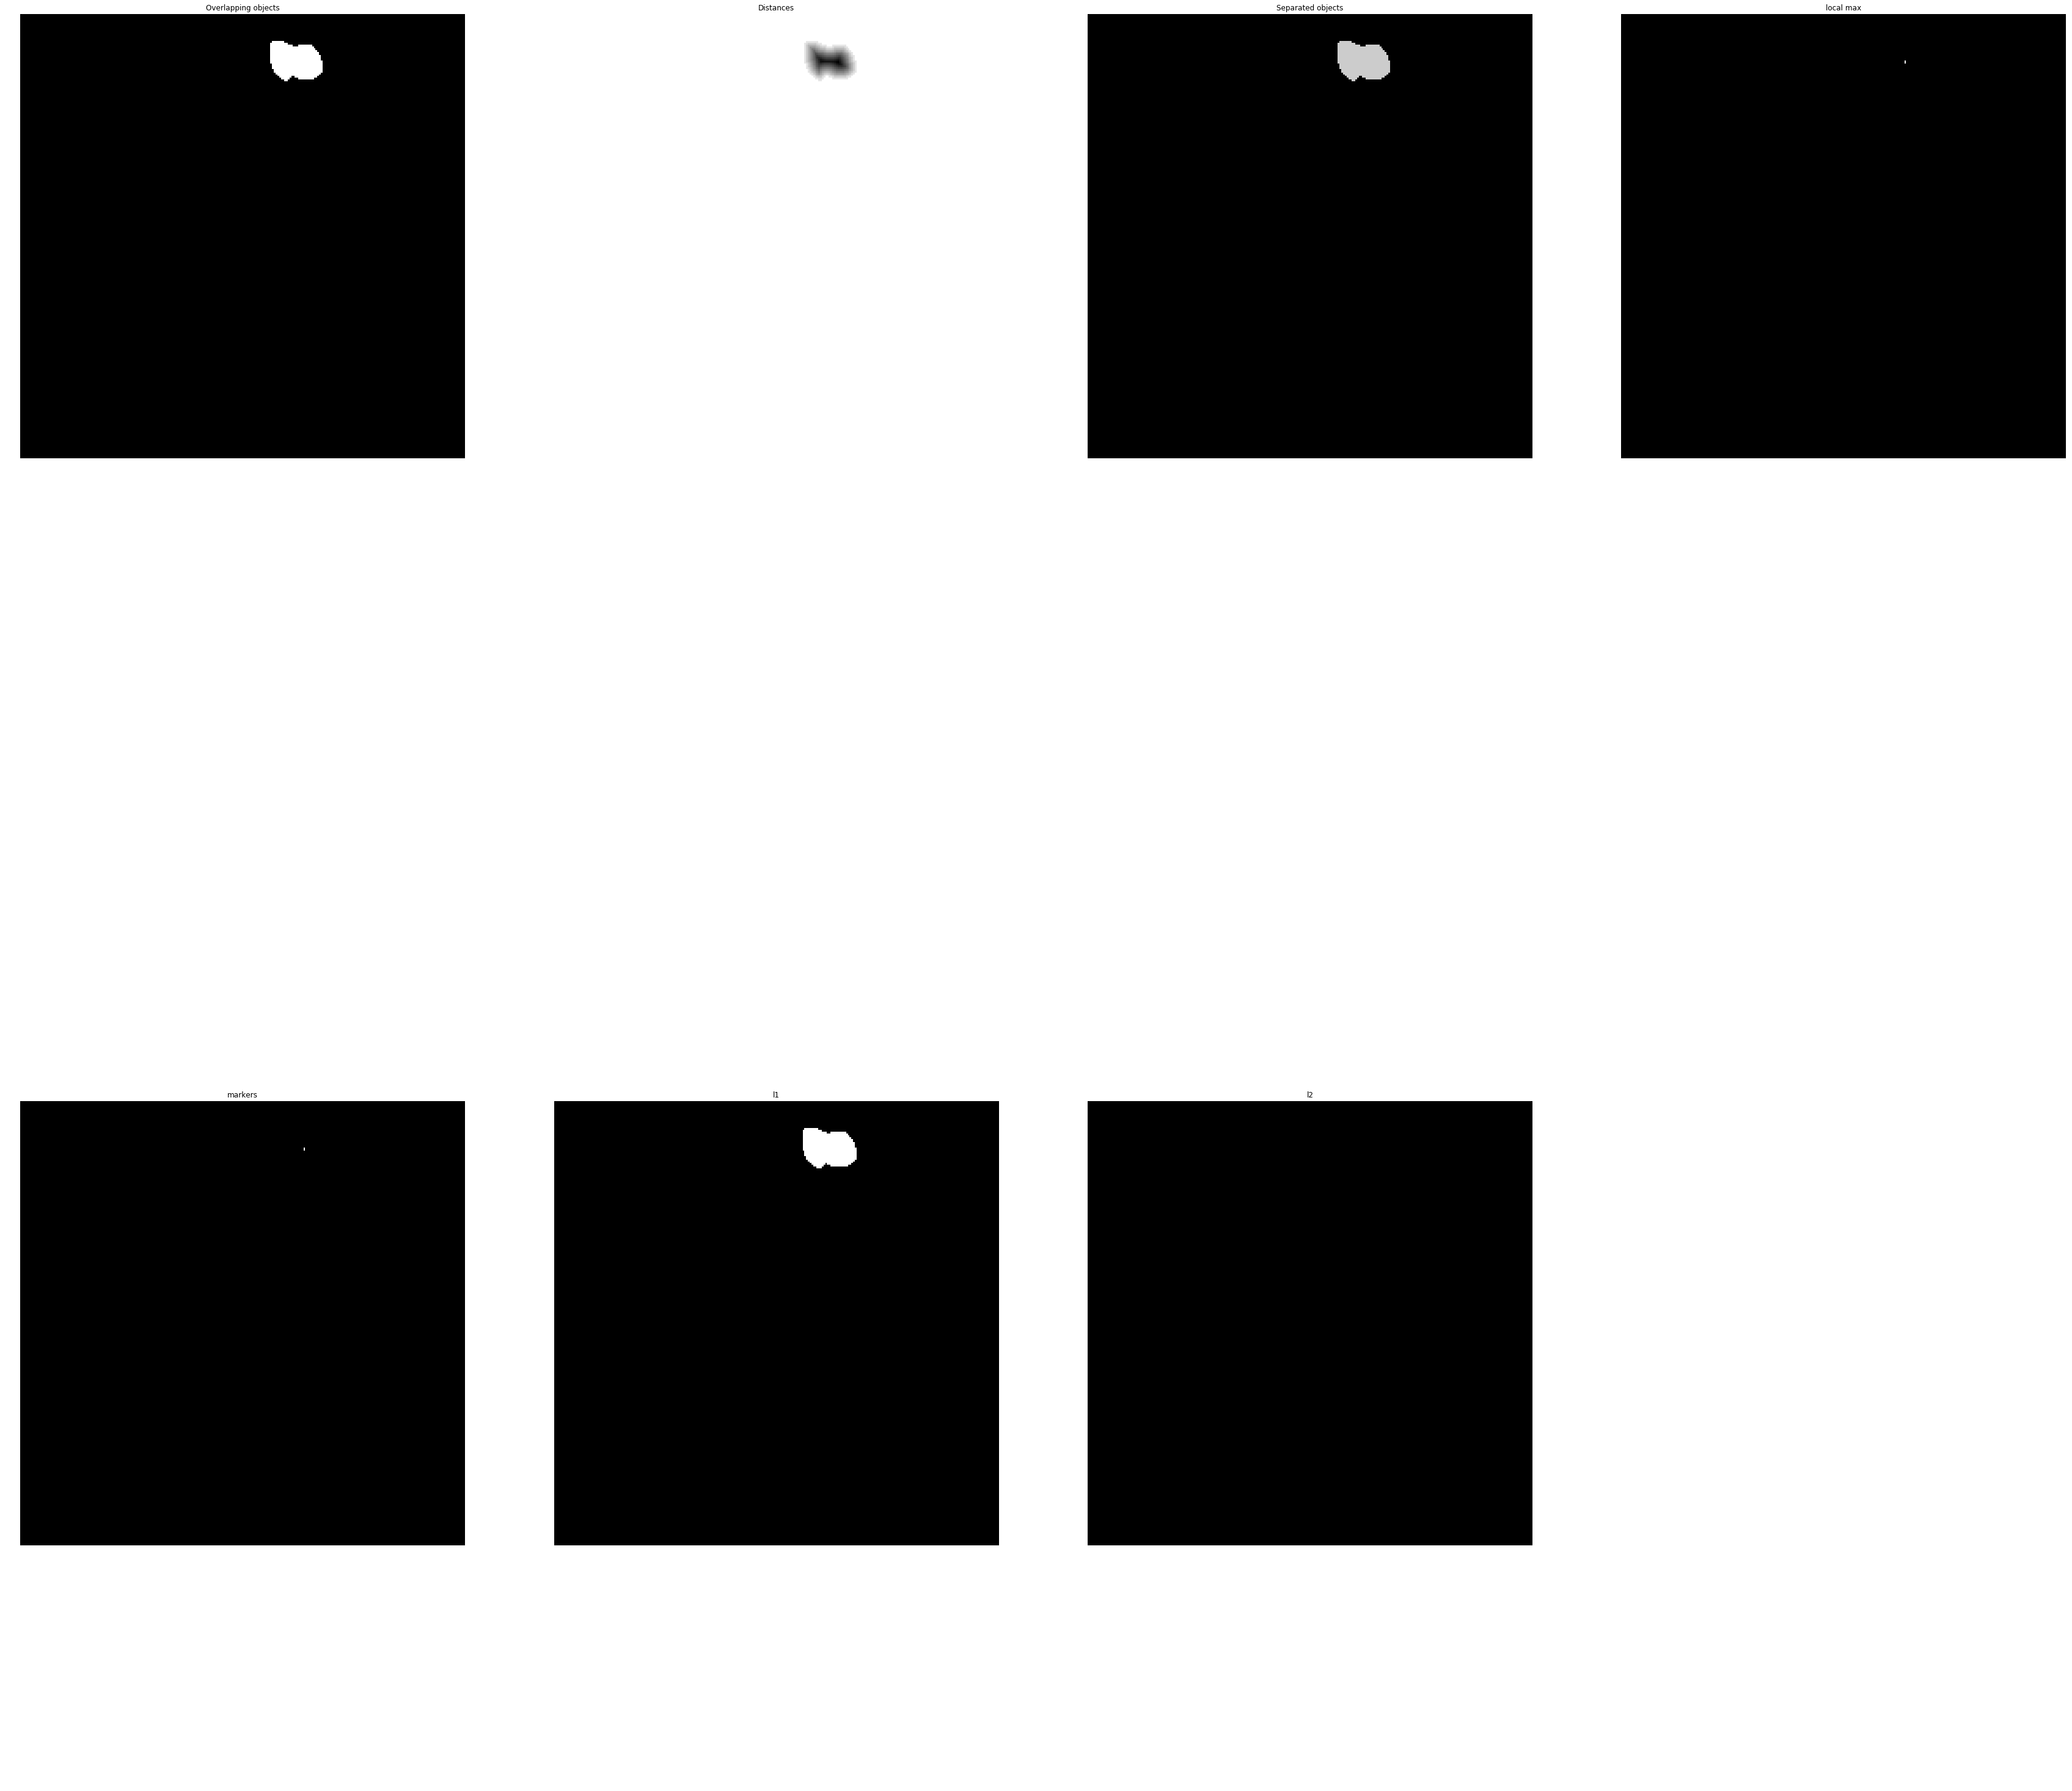

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.morphology import dilation
from PIL import Image

x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

image = Image.open('/home/jfaath/Desktop/test_images/combine-1.png')
image = np.asarray(image)

distance = ndi.distance_transform_edt(image)
#print(distance[25:35,25:35])
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((20, 20)),
                            labels=(image==255))
print(local_maxi.shape)
print(np.where(local_maxi==True))

marker_full = ndi.label(local_maxi)
label_res = ndi.label(local_maxi)
markers = label_res[0]
print(f"num markers: {label_res[1]}")
print(markers.shape)
labels = watershed(-distance, markers, mask=image)
print(labels.shape)

l1 = np.asarray(labels==1, dtype=np.uint8)
l2 = np.asarray(labels==2, dtype=np.uint8)
l1 = dilation(l1, [[1,1]])

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60, 60), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
ax[2].set_title('Separated objects')
ax[3].imshow(local_maxi, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('local max')
ax[4].imshow(markers, cmap=plt.cm.gray, interpolation='nearest')
ax[4].set_title('markers')
ax[5].imshow(l1, cmap=plt.cm.gray, interpolation='nearest')
ax[5].set_title('l1')
ax[6].imshow(l2, cmap=plt.cm.gray, interpolation='nearest')
ax[6].set_title('l2')


for a in ax:
    a.set_axis_off()

#fig.tight_layout()
plt.show()

^^^
Flow:
1. Get distance transform (distance to closest edge)
2. Get local max of the distances
3. Local max is a boolean result, running 'label' will turn it into array with labels 1,2,... at the single points of the max. These are the markers for the watershed. The 'label' method returns the number of labels.
4. Watershed will fill in the 1s, 2s etc. This needs to be separated into different masks. Use number of labels

The footprint argument in the peak_local_max method is important. If I don't have it in there or it's too small, it will produce a lot of max and therefore a lot of separations. Should adjust based on image size. (10x10) works in examples used so far, when going to 20x20, it didn't separate one. Another hyperparameter to play with I suppose.